# Data Cleaning
## Introduction and Problem Statement
The goal of this project is to analyze the screenplays for the Batman films directed by Tim Burton and the Dark Knight films from Christopher Nolan. Specifically, we'll look at the differences in language in the movies to see if a distinction can be made in the overall tone of the Burton films vs the Nolan films.

In this notebook, we'll clean the data to prepare it for natural language processing and do some initial exploratory data analysis to look at statistics such as the number of lines each character has.

In [1]:
# data analysis and manipulation
import pandas as pd
import numpy as np

# text manipulation
import re
import string

# files
import pickle

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# nlp
import nltk
from nltk.stem import WordNetLemmatizer

# topic modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Getting the Data
The screenplays are currently in a text file format. After inspecting the files, the lines in the documents follow a particular format in most of the scripts. There is a certain amount of whitespace that precedes a character's name and below that are the character's lines followed by another two or more newlines to provide distinction. We'll write a function below to handle this pattern and parse the files to store in a list of tuples for transfer to a DataFrame. Specifically, the scene number, character, and dialogue will be stored in each tuple.

In [2]:
# file path in local directory
path = 'batman-scripts/batman-scripts-txt/'

In [3]:
def screenplay_parser(filename, prefix):
    '''
    This function takes in a file and the spacing before a character's name
    in a movie screenplay and returns the parsed speaking lines for each
    character in a dictionary format.
    '''
    my_list = []
    with open(filename) as f:
        scene = 0
        is_dialogue = False
        dialogue_str = ""
        name = ""
        for line in f:
            # strip the first four characters of a line
            line_start = line.strip()[:4].upper()
            # check if the characters signify a scene
            if line_start == 'EXT.' or line_start == 'INT.':
                scene += 1
            if is_dialogue:
                # check if the end of a character's dialogue has been reached
                if line.strip() == "":
                    is_dialogue = False
                    my_list.append((scene, name, dialogue_str))
                else:
                    dialogue_str += line.strip() + " "
            # check for the spacing that precedes a character's name
            if line.startswith(prefix):
                name = line.strip()
                is_dialogue = True
                dialogue_str = ""

    return my_list

As mentioned, most of the files follow a pattern than can identify a character and dialogue by preceding whitespace. However, the Dark Knight screenplay does not have whitespace that precedes a character's name, so the below function will identify when a character's dialogue starts based on the capital letters in their name.

In [4]:
def screenplay_parser1(filename):
    '''
    This function takes in a file and returns the parsed speaking lines for each
    character in a dictionary format based on the capital letters in the script
    that designate the actor's name.
    '''
    my_list = []
    with open(filename) as f:
        scene = 0
        is_dialogue = False
        dialogue_str = ""
        name = ""
        for line in f:
            # strip the first four characters of a line
            line_start = line.strip()[:4].upper()
            # check if the characters signify a scene
            if line_start == 'EXT.' or line_start == 'INT.':
                scene += 1
            if is_dialogue:
                # check if the end of a character's dialogue has been reached
                if line.strip() == "":
                    is_dialogue = False
                    # add dialogue to the character's list of lines
                    my_list.append((scene, name, dialogue_str))
                else:
                    dialogue_str += line.strip() + " "
            # check for the spacing that precedes a character's name
            if line.isupper():
                name = line.strip()
                is_dialogue = True
                dialogue_str = ""

    return my_list

The functions can now be used to retrieve the information needed for analaysis to input in separate lists.

In [5]:
filename = path + 'batman.txt'
spacing = '                                '

batman = screenplay_parser(filename, spacing)

In [6]:
filename = path + 'batman_returns.txt'
spacing = '                             '

batman_returns = screenplay_parser(filename, spacing)

In [7]:
filename = path + 'batman_begins.txt'
spacing = '                                '

batman_begins = screenplay_parser(filename, spacing)

The Dark Knight corpus is unique, so we'll read in the text with the use of the `screenplay_parser1` function.

In [8]:
filename = path + 'dark_knight.txt'
spacing = ''

dark_knight = screenplay_parser1(filename)

In [9]:
filename = path + 'dark_knight_rises.txt'
spacing = '                          '

dark_knight_rises = screenplay_parser(filename, spacing)

## Create Dialogue-By-Character DataFrame
The lists can now be transformed to DataFrames.

In [10]:
df_bat = pd.DataFrame(batman, columns =['scene', 'character', 'dialogue'])
df_bat.head(10)

,scene,character,dialogue
0,2,MOM,"For God's sake, Harold, can we please just get..."
1,2,DAD,I'm trying to get a -- (shouting) TAXI!
2,2,JIMMY,We're going the wrong way.
3,2,DAD,Put that AWAY. We'll look like tourists.
4,2,DAD,We'll never get a cab. Let's cut over to Seve...
5,2,JIMMY,Seventh is that way.
6,2,DAD,I know where we are!
7,3,DERELICT,"Hey, mister. Gimme a dollar?"
8,3,DERELICT,Mister. How about it. One dollar? (standing ...
9,3,NICK,"Do the kid a favor, lady. Don't scream."


In [11]:
df_bat_ret = pd.DataFrame(batman_returns, columns =['scene', 'character', 'dialogue'])
df_bat_ret.head()

,scene,character,dialogue
0,2,GIDDY YULETIDE SINGERS,"""He knows when you are sleeping, he knows when..."
1,3,HAPPY COUPLE,Merry Christmas!
2,8,SWEET MICROPHONED VOICE,"Could I have your attention, Gotham City?"
3,9,ICE PRINCESS,It's time for tonight's Lighting of the Tree! ...
4,11,THE CREEPY LIPS,"""I know when you are sleeping, I know when you..."


In [12]:
df_bat_beg = pd.DataFrame(batman_begins, columns =['scene', 'character', 'dialogue'])
df_bat_beg.head()

,scene,character,dialogue
0,1,YOUNG BRUCE WAYNE,Rachel?
1,1,MRS DODSON,Rachel?! Master Bruce?!
2,1,YOUNG BRUCE WAYNE,(whispering) What're you doing?!
3,2,RACHEL DAWES,"Bruce, I can see you."
4,4,RACHEL DAWES,BRUCE?!!


In [13]:
df_dk = pd.DataFrame(dark_knight, columns =['scene', 'character', 'dialogue'])
df_dk.head()

,scene,character,dialogue
0,2,CLOWNS,Three of a kind. Let's do this.
1,2,CLOWNS,That's it? Three guys?
2,2,CLOWNS,There's two on the roof. Every guy is an extra...
3,2,CLOWNS,Six shares. Don't forget the guy who planned t...
4,2,CLOWNS,Yeah? He thinks he can sit it out and still ta...


In [14]:
df_dkr = pd.DataFrame(dark_knight_rises, columns =['scene', 'character', 'dialogue'])
df_dkr.head()

,scene,character,dialogue
0,0,JIM GORDON,Harvey Dent was needed. He was everything Goth...
1,1,JIM GORDON,But I knew Harvey Dent. I was...his friend. An...
2,3,CIA MAN,"Dr. Pavel, I'm CIA. (Dr. Pavel nods, nervous. ..."
3,3,DRIVERS,"He wasn't alone. (CIA Man, confused, spots the..."
4,3,CIA MAN,You don't get to bring friends.


In [15]:
# look at the columns in one of the dataframes
df_bat.character.value_counts()[:10]

VICKI VALE        149
JOKER             111
ALEXANDER KNOX     76
BRUCE WAYNE        63
BATMAN             42
JACK NAPIER        25
ALFRED             19
LT ECKHARDT        14
THUGS              12
NICK               12
Name: character, dtype: int64

### Check for Duplicates
Before continuing, let's also check for duplicates.

In [16]:
print("Duplicates for...\nBatman: {}\nBatman Returns: {}\nBatman Begins: {}\nDark Knight: {}\nDark Knight Rises: {}"
      .format(df_bat.dialogue.duplicated().sum(), df_bat_ret.dialogue.duplicated().sum(),
              df_bat_beg.dialogue.duplicated().sum(), df_dk.dialogue.duplicated().sum(),
              df_dkr.dialogue.duplicated().sum()))

Duplicates for...
Batman: 4
Batman Returns: 2
Batman Begins: 20
Dark Knight: 14
Dark Knight Rises: 16


Several of these scripts appear to contain duplicates, so let's inspect.

In [17]:
# inspect the values for the duplicate row
df_bat[df_bat.dialogue.duplicated(keep=False)]

,scene,character,dialogue
115,15,VICKI VALE,Thanks.
235,30,JACK NAPIER,Mirror.
236,30,JACK NAPIER,Mirror.
416,66,COMPUTER,Ignition.
437,80,BATMAN,Shields open.
438,81,COMPUTER,Shields open.
440,81,COMPUTER,Ignition.
547,113,BATMAN,Thanks.


In [18]:
df_bat_ret[df_bat_ret.dialogue.duplicated(keep=False)]

,scene,character,dialogue
42,33,BATMAN,Sure.
386,92,SELINA KYLE,Sure.
446,137,PENGUIN,Ya gotta admit ... I've played this stinking c...
466,149,PENGUIN,Ya gotta admit ... I've played this stinking c...


The lines from Batman and Selina Kyle aren't hard to imagine being spoken by two different character's in a movie, but the duplicates from Penguin seem unlikely. Upon searching for the lines in the script, however, the Penguin does indeed say this line twice. The script gives context.

In [19]:
df_bat_beg[df_bat_beg.dialogue.duplicated(keep=False)]

,scene,character,dialogue
25,10,BRUCE WAYNE,Who are you?
37,11,THOMAS WAYNE,Bruce?
40,12,ALFRED,"Very good, sir."
44,14,ALFRED,So that we might better learn to pick ourselve...
150,38,ALFRED,(conviction) Never.
207,52,HOMELESS MAN,For what?
211,52,HOMELESS MAN,Who?
252,62,BRUCE WAYNE,For what?
259,62,BRUCE WAYNE,What's necessary.
350,91,JIM GORDON,What do you want?


For Batman Begins, a lot of text is a short word or phrase and is indeed repeated throughout the movie among multiple characters. The line that is suspicious is Alfreds where he says, "So that we might better learn to pick ourselves up." This occurs twice in the movie, once near the beginning and once near the end, and is an artistic touch and not an actual duplicate.

In [20]:
df_dk[df_dk.dialogue.duplicated(keep=False)]

,scene,character,dialogue
42,21,JIM GORDON,I'm sorry.
169,41,HARVEY DENT,What?
236,47,JOKER,Half.
505,123,LUCIUS FOX,Fair enough.
518,138,DET STEPHENS,I'm sorry.
542,144,BATMAN,Where is he?
556,145,HARVEY DENT,Not exactly.
562,145,HARVEY DENT,Why?
573,146,RACHEL DAWES,Yes.
662,215,JOKER,Of course not.


In [21]:
df_dkr[df_dkr.dialogue.duplicated(keep=False)]

,scene,character,dialogue
31,7,MILITARY,Sir?
105,22,JOHN BLAKE,Sir?
145,28,JOHN BLAKE,Why?
187,34,COPS,Where?
275,48,BRUCE WAYNE,Why?
377,61,BRUCE WAYNE,Bane.
431,75,JOHN BLAKE,What's that?
638,109,SELINA KYLE,Why?
645,111,JIM GORDON,Why?
667,113,MIRANDA TATE,What's that?


The last three movies (those from Christopher Nolan) also do not include actual duplicates. For one thing, many of the rows are words repeated by separate characters, and for another, those spoken by the same character are either common and would be expected to be repeated in a movie or have some context around them that makes them a deliberate choice by the writer for the character to say more than once. We're good to go, but it's imperative to check these things before moving forward to ensure that the model has text to work with that won't affect its performance.

### Format and Combine the Data
The next task will be to concatenate the DataFrames and merge the data. So that information specific to each movie is not lost, a column containing the movie title will be added to each DataFrame beforehand. Additionally, the character name column can be put in a title format.

In [22]:
# insert column for movie title

df_bat.insert(0, 'director', 'Tim Burton')
df_bat.insert(1, 'movie', 'Batman')
df_bat['character'] = df_bat.character.str.title()

df_bat_ret.insert(0, 'director', 'Tim Burton')
df_bat_ret.insert(1, 'movie', 'Batman Returns')
df_bat_ret['character'] = df_bat_ret.character.str.title()

df_bat_beg.insert(0, 'director', 'Christopher Nolan')
df_bat_beg.insert(1, 'movie', 'Batman Begins')
df_bat_beg['character'] = df_bat_beg.character.str.title()

df_dk.insert(0, 'director', 'Christopher Nolan')
df_dk.insert(1, 'movie', 'The Dark Knight')
df_dk['character'] = df_dk.character.str.title()

df_dkr.insert(0, 'director', 'Christopher Nolan')
df_dkr.insert(1, 'movie', 'The Dark Knight Rises')
df_dkr['character'] = df_dkr.character.str.title()

In [23]:
# combine the dataframes

df_list = [df_bat, df_bat_ret, df_bat_beg, df_dk, df_dkr]

df_character = pd.concat(df_list)
df_character

,director,movie,scene,character,dialogue
0,Tim Burton,Batman,2,Mom,"For God's sake, Harold, can we please just get..."
1,Tim Burton,Batman,2,Dad,I'm trying to get a -- (shouting) TAXI!
2,Tim Burton,Batman,2,Jimmy,We're going the wrong way.
3,Tim Burton,Batman,2,Dad,Put that AWAY. We'll look like tourists.
4,Tim Burton,Batman,2,Dad,We'll never get a cab. Let's cut over to Seve...
...,...,...,...,...,...
1221,Christopher Nolan,The Dark Knight Rises,305,Workers,"But Mr. Fox, it's already been fixed. (Typed o..."
1222,Christopher Nolan,The Dark Knight Rises,305,Lucius Fox,Check the user ident on the patch...
1223,Christopher Nolan,The Dark Knight Rises,305,Workers,Huh. Bruce Wayne.
1224,Christopher Nolan,The Dark Knight Rises,307,Waiter,Lei e solo?


/Users/willnobles/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

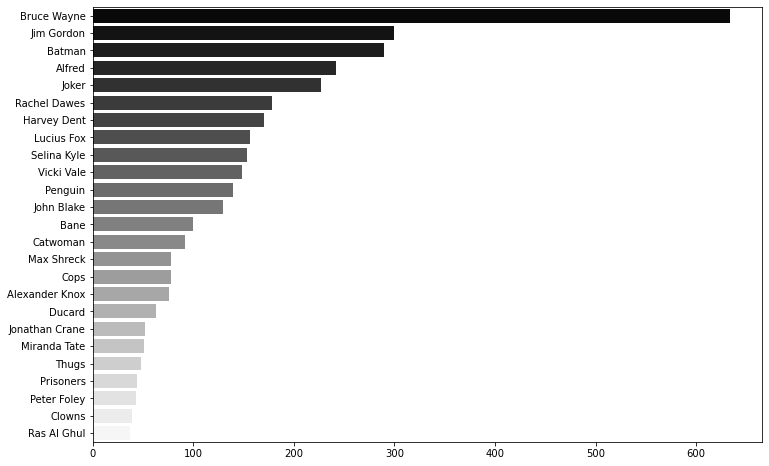

In [24]:
counts = df_character.character.value_counts()[:25]

plt.figure(figsize=(12, 8))
sns.barplot(counts.values, counts.index, palette='gist_gray')

## Create Dialogue-By-Scene DataFrame
The above DataFrame may be useful for certain tasks related to natural language processing, but for topic modeling it will be more beneficial to have each document in the corpus contain all the dialogue for a scene rather than contain lines for each character. The original DataFrames will be grouped by scene and the dialogue will be concatenated. Addiitonally, the characters for each scene will be grouped into a list of unique values before transforming both series to another DataFrame.

In [25]:
# create two series by dialogue and character, respectively
scene_dialogue = df_bat.groupby('scene')['dialogue'].apply(lambda x: x.str.cat(sep=' '))
scene_characters = df_bat.groupby('scene')['character'].apply(lambda x: x.str.cat(sep=' '))
scene_characters = scene_characters.apply(lambda x: list(set(x.split())))

#convert to a dataframe
df_bat_scene = pd.concat([scene_characters, scene_dialogue], axis=1).reset_index()

In [26]:
# create two series by dialoge and character, respectively
scene_dialogue = df_bat_ret.groupby('scene')['dialogue'].apply(lambda x: x.str.cat(sep=' '))
scene_characters = df_bat_ret.groupby('scene')['character'].apply(lambda x: x.str.cat(sep=' '))
scene_characters = scene_characters.apply(lambda x: list(set(x.split())))

# convert to a dataframe
df_bat_ret_scene = pd.concat([scene_characters, scene_dialogue], axis=1).reset_index()

In [27]:
# create two series by dialoge and character, respectively
scene_dialogue = df_bat_beg.groupby('scene')['dialogue'].apply(lambda x: x.str.cat(sep=' '))
scene_characters = df_bat_beg.groupby('scene')['character'].apply(lambda x: x.str.cat(sep=' '))
scene_characters = scene_characters.apply(lambda x: list(set(x.split())))

# convert to a dataframe
df_bat_beg_scene = pd.concat([scene_characters, scene_dialogue], axis=1).reset_index()

In [28]:
# create two series by dialoge and character, respectively
scene_dialogue = df_dk.groupby('scene')['dialogue'].apply(lambda x: x.str.cat(sep=' '))
scene_characters = df_dk.groupby('scene')['character'].apply(lambda x: x.str.cat(sep=' '))
scene_characters = scene_characters.apply(lambda x: list(set(x.split())))

# convert to a dataframe
df_dk_scene = pd.concat([scene_characters, scene_dialogue], axis=1).reset_index()

In [29]:
# create two series by dialoge and character, respectively
scene_dialogue = df_dkr.groupby('scene')['dialogue'].apply(lambda x: x.str.cat(sep=' '))
scene_characters = df_dkr.groupby('scene')['character'].apply(lambda x: x.str.cat(sep=' '))
scene_characters = scene_characters.apply(lambda x: list(set(x.split())))

# convert to a dataframe
df_dkr_scene = pd.concat([scene_characters, scene_dialogue], axis=1).reset_index()

### Format and Combine the Data
The `director` and `movie` columns must be added back in once more before concatenating the DataFrames.

In [30]:
# insert column for movie title

df_bat_scene.insert(0, 'director', 'Tim Burton')
df_bat_scene.insert(1, 'movie', 'Batman')

df_bat_ret_scene.insert(0, 'director', 'Tim Burton')
df_bat_ret_scene.insert(1, 'movie', 'Batman Returns')

df_bat_beg_scene.insert(0, 'director', 'Christopher Nolan')
df_bat_beg_scene.insert(1, 'movie', 'Batman Begins')

df_dk_scene.insert(0, 'director', 'Christopher Nolan')
df_dk_scene.insert(1, 'movie', 'The Dark Knight')

df_dkr_scene.insert(0, 'director', 'Christopher Nolan')
df_dkr_scene.insert(1, 'movie', 'The Dark Knight Rises')

In [31]:
# combine the dataframes

df_list = [df_bat_scene, df_bat_ret_scene, df_bat_beg_scene, df_dk_scene, df_dkr_scene]

df = pd.concat(df_list)
df

,director,movie,scene,character,dialogue
0,Tim Burton,Batman,2,"[Dad, Jimmy, Mom]","For God's sake, Harold, can we please just get..."
1,Tim Burton,Batman,3,"[Nick, Derelict]","Hey, mister. Gimme a dollar? Mister. How ab..."
2,Tim Burton,Batman,5,"[Batman, Nick, Eddie]",Alright! American Express. (tossing the credit...
3,Tim Burton,Batman,6,"[Harvey, Dent, Borg, Mayor]","Across this nation, the words 'Gotham City' ar..."
4,Tim Burton,Batman,7,"[Jack, Hunt, Alicia, Dent, Napier, Harvey]",(on the TV screen) Together we can make this c...
...,...,...,...,...,...
201,Christopher Nolan,The Dark Knight Rises,302,[Lawyers],The house and grounds are left to the city of ...
202,Christopher Nolan,The Dark Knight Rises,303,[Lawyers],"And that they shall be used for one purpose, a..."
203,Christopher Nolan,The Dark Knight Rises,304,"[Lawyers, John, Blake]",My clerk will help anyone with the smaller cor...
204,Christopher Nolan,The Dark Knight Rises,305,"[Fox, Lucius, Workers]",Why worry about the stabilization software? Th...


In [32]:
# format the dataframe to include movie and scene information as an index
df['movie_scene'] = df['movie'] + ' Scene ' + df['scene'].astype(str)
df = df.set_index('movie_scene')
df.index.name = None
df

,director,movie,scene,character,dialogue
Batman Scene 2,Tim Burton,Batman,2,"[Dad, Jimmy, Mom]","For God's sake, Harold, can we please just get..."
Batman Scene 3,Tim Burton,Batman,3,"[Nick, Derelict]","Hey, mister. Gimme a dollar? Mister. How ab..."
Batman Scene 5,Tim Burton,Batman,5,"[Batman, Nick, Eddie]",Alright! American Express. (tossing the credit...
Batman Scene 6,Tim Burton,Batman,6,"[Harvey, Dent, Borg, Mayor]","Across this nation, the words 'Gotham City' ar..."
Batman Scene 7,Tim Burton,Batman,7,"[Jack, Hunt, Alicia, Dent, Napier, Harvey]",(on the TV screen) Together we can make this c...
...,...,...,...,...,...
The Dark Knight Rises Scene 302,Christopher Nolan,The Dark Knight Rises,302,[Lawyers],The house and grounds are left to the city of ...
The Dark Knight Rises Scene 303,Christopher Nolan,The Dark Knight Rises,303,[Lawyers],"And that they shall be used for one purpose, a..."
The Dark Knight Rises Scene 304,Christopher Nolan,The Dark Knight Rises,304,"[Lawyers, John, Blake]",My clerk will help anyone with the smaller cor...
The Dark Knight Rises Scene 305,Christopher Nolan,The Dark Knight Rises,305,"[Fox, Lucius, Workers]",Why worry about the stabilization software? Th...


## Cleaning the Data
In addition to the common data cleaning steps taken in text preprocessing, it is important to note some of the unique aspects of the corpora that need to be cleaned, as well. One thing to include in our text preprocessing is the bits of text surrounded by parentheses in the corpora that are not part of a character's dialogue, but instead denote some action or direction for the character.

**BANE**: *(rising) With no survivors.*

Another way the writing in some of the screenplays is unique is how the writers incorporate dashes or hyphens.

**VICKI**: *I'm Vicki Vale -- I had a message to meet Bruce Wayne here.*

These two cases will be included in our function when we clean the text.

In [33]:
def clean_text(text):
    '''
    This function makes text lowercase,
    removes numbers,
    removes words and phrases surrounded by parentheses,
    removes punctuation,
    and removes two consecutive dashes
    '''
    text = text.lower()
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\(.*\)', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('--', '', text)
    return text

cleaned = lambda x: clean_text(x) if pd.notnull(x) else x

In [34]:
# clean the text for both dataframes

df_character['dialogue'] = df_character.dialogue.apply(cleaned)
df['dialogue'] = df.dialogue.apply(cleaned)
df

,director,movie,scene,character,dialogue
Batman Scene 2,Tim Burton,Batman,2,"[Dad, Jimmy, Mom]",for gods sake harold can we please just get a ...
Batman Scene 3,Tim Burton,Batman,3,"[Nick, Derelict]",hey mister gimme a dollar mister how about ...
Batman Scene 5,Tim Burton,Batman,5,"[Batman, Nick, Eddie]",alright american express there aint no bat y...
Batman Scene 6,Tim Burton,Batman,6,"[Harvey, Dent, Borg, Mayor]",across this nation the words gotham city are s...
Batman Scene 7,Tim Burton,Batman,7,"[Jack, Hunt, Alicia, Dent, Napier, Harvey]",and besides he doesnt know you dont worry ab...
...,...,...,...,...,...
The Dark Knight Rises Scene 302,Christopher Nolan,The Dark Knight Rises,302,[Lawyers],the house and grounds are left to the city of ...
The Dark Knight Rises Scene 303,Christopher Nolan,The Dark Knight Rises,303,[Lawyers],and that they shall be used for one purpose an...
The Dark Knight Rises Scene 304,Christopher Nolan,The Dark Knight Rises,304,"[Lawyers, John, Blake]",my clerk will help anyone with the smaller cor...
The Dark Knight Rises Scene 305,Christopher Nolan,The Dark Knight Rises,305,"[Fox, Lucius, Workers]",why worry about the stabilization software thi...


In [35]:
# add lemmatization for both dataframes

lemmatizer = WordNetLemmatizer()

df_character['dialogue_tokens'] = df_character.dialogue.str.split()
df_character['dialogue_lemmatized'] = df_character.dialogue_tokens.apply(lambda x: ' '.join([lemmatizer.lemmatize(y) for y in x]))
df_character.drop(columns=['dialogue_tokens'], inplace=True)

df['dialogue_tokens'] = df.dialogue.str.split()
df['dialogue_lemmatized'] = df.dialogue_tokens.apply(lambda x: ' '.join([lemmatizer.lemmatize(y) for y in x]))
df.drop(columns=['dialogue_tokens'], inplace=True)
df

,director,movie,scene,character,dialogue,dialogue_lemmatized
Batman Scene 2,Tim Burton,Batman,2,"[Dad, Jimmy, Mom]",for gods sake harold can we please just get a ...,for god sake harold can we please just get a t...
Batman Scene 3,Tim Burton,Batman,3,"[Nick, Derelict]",hey mister gimme a dollar mister how about ...,hey mister gimme a dollar mister how about it ...
Batman Scene 5,Tim Burton,Batman,5,"[Batman, Nick, Eddie]",alright american express there aint no bat y...,alright american express there aint no bat you...
Batman Scene 6,Tim Burton,Batman,6,"[Harvey, Dent, Borg, Mayor]",across this nation the words gotham city are s...,across this nation the word gotham city are sy...
Batman Scene 7,Tim Burton,Batman,7,"[Jack, Hunt, Alicia, Dent, Napier, Harvey]",and besides he doesnt know you dont worry ab...,and besides he doesnt know you dont worry abou...
...,...,...,...,...,...,...
The Dark Knight Rises Scene 302,Christopher Nolan,The Dark Knight Rises,302,[Lawyers],the house and grounds are left to the city of ...,the house and ground are left to the city of g...
The Dark Knight Rises Scene 303,Christopher Nolan,The Dark Knight Rises,303,[Lawyers],and that they shall be used for one purpose an...,and that they shall be used for one purpose an...
The Dark Knight Rises Scene 304,Christopher Nolan,The Dark Knight Rises,304,"[Lawyers, John, Blake]",my clerk will help anyone with the smaller cor...,my clerk will help anyone with the smaller cor...
The Dark Knight Rises Scene 305,Christopher Nolan,The Dark Knight Rises,305,"[Fox, Lucius, Workers]",why worry about the stabilization software thi...,why worry about the stabilization software thi...


## Organizing the Data
The cleaned dialogue, contained in the `dialogue` and `dialogue_lemmatized` columns, from the by-scene DataFrame is the corpus and will be pickled and used later, both for EDA and topic modeling purposes. We'll take the entire dataset with us, however, in case the information in the other columns is helpful in gaining some unique insights during the EDA portion of the project.

In [36]:
# store the dataframe for later use
df_character.to_pickle('df_char.pkl')
df.to_pickle('df.pkl')